## Импортируем библотеки


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score

## Открываем наш датасет

In [2]:
df = pd.read_csv('/content/depress.csv')

In [4]:
df.head(-1)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2015-08-25 19:59:38,36,Male,United States,UT,No,Yes,No,Rarely,More than 1000,No,No,Don't know,No,Yes,Yes,Don't know,Somewhat easy,Maybe,Maybe,Some of them,Some of them,No,No,Don't know,No,NaN
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,No,Yes,No,No,No,No,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,Yes,Yes,Yes,Yes,No,No,Yes,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,No,Yes,Yes,Yes,No,No,Don't know,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN


In [5]:
df['Age'].describe()

count    1.259000e+03
mean     7.942815e+07
std      2.818299e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64

In [6]:
df.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

### Дропаем переменные (страна, штат, дата и время прохождения опроса, дополнительные комментарии), которые не относятся напрямую к вопросам о депрессии. 

In [7]:
df = df.drop(['Country', 'state', 'Timestamp', 'comments'], axis = 1)

### Далее изучем наши переменные. 
Заменяем NaN средними или самыми популярными значениями. 
Переделываем качественные переменные в категориальные.

In [8]:
df['work_interfere'].value_counts()

Sometimes    465
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64

In [9]:
df = df.fillna({'work_interfere': 'Затрудняюсь ответить'})
df.isnull().sum()

Age                           0
Gender                        0
self_employed                18
family_history                0
treatment                     0
work_interfere                0
no_employees                  0
remote_work                   0
tech_company                  0
benefits                      0
care_options                  0
wellness_program              0
seek_help                     0
anonymity                     0
leave                         0
mental_health_consequence     0
phys_health_consequence       0
coworkers                     0
supervisor                    0
mental_health_interview       0
phys_health_interview         0
mental_vs_physical            0
obs_consequence               0
dtype: int64

In [10]:
df['self_employed'].value_counts()

No     1095
Yes     146
Name: self_employed, dtype: int64

In [11]:
df = df.fillna({'self_employed': 'No'})
df.isnull().sum()

Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64

In [12]:
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,No,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,No,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,No,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,No,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,No,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [13]:
df['Gender'].value_counts()

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Woman                                               3
Male                                                3
Female (trans)                                      2
Man                                                 2
Female                                              2
Cis Male                                            2
cis-female/femme                                    1
Male (CIS)                                          1
maile                                               1
Genderqueer                 

In [14]:
df['Gender'].replace(['Male', 'male', 'M', 'm', 'Make', 'Male ', 'Cis Male', 'Man', 'ostensibly male, unsure what that really means', 'maile', 'Malr', 'Cis Man', 'Male-ish', 'msle', 'Male (CIS)', 'Mal', 'Guy (-ish) ^_^', 'Mail', 'cis male'], 'Male', inplace = True)
df['Gender'].replace(['Female', 'female', 'F', 'f', 'Woman', 'Female ', 'Female (trans)', 'Trans-female', 'cis-female/femme', 'Trans woman', 'Female (cis)', 'femail', 'Femake', 'Cis Female', 'woman'], 'Female', inplace=True)
df['Gender'].replace(['fluid', 'Enby', 'male leaning androgynous', 'Neuter', 'queer', 'p', 'something kinda male?', 'non-binary', 'Genderqueer', 'Androgyne', 'A little about you', 'All', 'Agender', 'Nah', 'queer/she/they'], 'Non-binary', inplace=True)

In [15]:
df['Gender'].value_counts()

Male          993
Female        251
Non-binary     15
Name: Gender, dtype: int64

In [16]:
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,No,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,Male,No,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,No,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,No,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,No,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


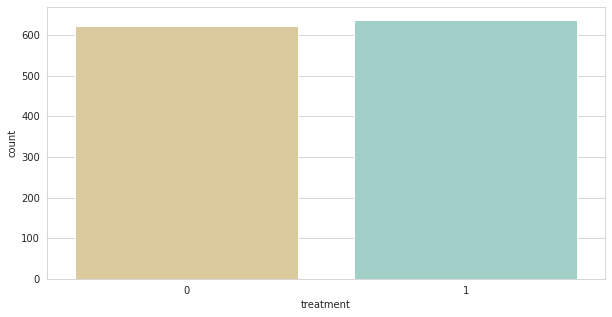

In [91]:
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid') 
sns.countplot(x='treatment', palette = "BrBG", data=df);

In [18]:
df['Age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 39             33
 40             33
 43             28
 41             21
 22             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 20              6
 48              6
 50              6
 51              5
 56              4
 49              4
 57              3
 54              3
 55              3
 47              2
 60              2
 11              1
 8               1
 5               1
 99999999999     1
-1726            1
 53              1
 58              1
 61              1
 62              1
 65              1
 72              1
 329             1
-29              1
-1          

In [19]:
df['Age'].replace([df['Age'][df['Age'] < 18]], np.nan, inplace = True)
df['Age'].replace([df['Age'][df['Age'] >100]], np.nan, inplace = True)

In [20]:
df['Age'].mean()

32.07673860911271

In [21]:
df = df.fillna({'Age': 32})

In [23]:
Self_employed_mapping = {"No": 0, "Yes": 1}
df['self_employed'] = df['self_employed'].map(Self_employed_mapping)
df['self_employed'].value_counts()

0    1113
1     146
Name: self_employed, dtype: int64

In [24]:
Family_history_mapping = {"No": 0, "Yes": 1}
df['family_history'] = df['family_history'].map(Family_history_mapping)
df['family_history'].value_counts()

0    767
1    492
Name: family_history, dtype: int64

In [25]:
Treatment_mapping = {"No": 0, "Yes": 1}
df['treatment'] = df['treatment'].map(Treatment_mapping)
df['treatment'].value_counts()

1    637
0    622
Name: treatment, dtype: int64

In [26]:
df['work_interfere'].value_counts()

Sometimes               465
Затрудняюсь ответить    264
Never                   213
Rarely                  173
Often                   144
Name: work_interfere, dtype: int64

In [27]:
Work_inference_mapping = {"Затрудняюсь ответить": 0, "Never": 1, "Rarely": 2, "Sometimes": 3, "Often": 4}
df['work_interfere'] = df['work_interfere'].map(Work_inference_mapping)
df['work_interfere'].value_counts()

3    465
0    264
1    213
2    173
4    144
Name: work_interfere, dtype: int64

In [28]:
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37.0,Female,0,0,1,4,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44.0,Male,0,0,0,2,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32.0,Male,0,0,0,2,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31.0,Male,0,1,1,4,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31.0,Male,0,0,0,1,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [29]:
df['no_employees'].value_counts()

6-25              290
26-100            289
More than 1000    282
100-500           176
1-5               162
500-1000           60
Name: no_employees, dtype: int64

In [30]:
No_employees_mapping = {"1-5": 0, "6-25": 1, "26-100": 2, "100-500": 3, "500-1000": 4, "More than 1000": 5}
df['no_employees'] = df['no_employees'].map(No_employees_mapping)
df['no_employees'].value_counts()

1    290
2    289
5    282
3    176
0    162
4     60
Name: no_employees, dtype: int64

In [31]:
df['benefits'].value_counts()

Yes           477
Don't know    408
No            374
Name: benefits, dtype: int64

In [32]:
Remote_work_mapping = {"No": 0, "Yes": 1}
df['remote_work'] = df['remote_work'].map(Remote_work_mapping)
df['remote_work'].value_counts()

0    883
1    376
Name: remote_work, dtype: int64

In [33]:
Tech_company_mapping = {"No": 0, "Yes": 1}
df['tech_company'] = df['tech_company'].map(Tech_company_mapping)
df['tech_company'].value_counts()

1    1031
0     228
Name: tech_company, dtype: int64

In [34]:
Benefits_mapping = {"No": 0, "Don't know": 1, "Yes": 2}
df['benefits'] = df['benefits'].map(Benefits_mapping)
df['benefits'].value_counts()

2    477
1    408
0    374
Name: benefits, dtype: int64

In [35]:
Benefits_mapping = {0: 0, 1: 0, 2: 1}
df['benefits'] = df['benefits'].map(Benefits_mapping)
df['benefits'].value_counts()

0    782
1    477
Name: benefits, dtype: int64

In [36]:
Care_options_mapping = {"No": 0, "Not sure": 1, "Yes": 2}
df['care_options'] = df['care_options'].map(Care_options_mapping)
df['care_options'].value_counts()

0    501
2    444
1    314
Name: care_options, dtype: int64

In [37]:
Care_options_mapping = {0: 0, 1: 0, 2: 1}
df['care_options'] = df['care_options'].map(Care_options_mapping)
df['care_options'].value_counts()

0    815
1    444
Name: care_options, dtype: int64

In [38]:
Wellness_mapping = {"Don't know": 0, "No": 1, "Yes": 2}
df['wellness_program'] = df['wellness_program'].map(Wellness_mapping)
df['wellness_program'].value_counts()

1    842
2    229
0    188
Name: wellness_program, dtype: int64

In [39]:
Wellness_mapping = {0: 0, 1: 0, 2: 1}
df['wellness_program'] = df['wellness_program'].map(Wellness_mapping)
df['wellness_program'].value_counts()

0    1030
1     229
Name: wellness_program, dtype: int64

In [40]:
Seek_help_mapping = {"Don't know": 0, "No": 1, "Yes": 2}
df['seek_help'] = df['seek_help'].map(Seek_help_mapping)
df['seek_help'].value_counts()

1    646
0    363
2    250
Name: seek_help, dtype: int64

In [41]:
Seek_help_mapping = {0: 0, 1: 0, 2: 1}
df['seek_help'] = df['seek_help'].map(Seek_help_mapping)
df['seek_help'].value_counts()

0    1009
1     250
Name: seek_help, dtype: int64

In [42]:
Anonymity_mapping = {"Don't know": 0, "No": 1, "Yes": 2}
df['anonymity'] = df['anonymity'].map(Anonymity_mapping)
df['anonymity'].value_counts()

0    819
2    375
1     65
Name: anonymity, dtype: int64

In [43]:
Leave_mapping = {"Don't know": 0, "Very easy": 1, "Somewhat easy": 2, "Somewhat difficult": 3, "Very difficult": 4}
df['leave'] = df['leave'].map(Leave_mapping)
df['leave'].value_counts()

0    563
2    266
1    206
3    126
4     98
Name: leave, dtype: int64

In [44]:
Mental_health_mapping = {"No": 0, "Maybe": 1, "Yes": 2}
df['mental_health_consequence'] = df['mental_health_consequence'].map(Mental_health_mapping)
df['mental_health_consequence'].value_counts()

0    490
1    477
2    292
Name: mental_health_consequence, dtype: int64

In [45]:
Phys_health_mapping = {"No": 0, "Maybe": 1, "Yes": 2}
df['phys_health_consequence'] = df['phys_health_consequence'].map(Phys_health_mapping)
df['phys_health_consequence'].value_counts()

0    925
1    273
2     61
Name: phys_health_consequence, dtype: int64

In [46]:
Coworkers_mapping = {"No": 0, "Some of them": 1, "Yes": 2}
df['coworkers'] = df['coworkers'].map(Coworkers_mapping)
df['coworkers'].value_counts()

1    774
0    260
2    225
Name: coworkers, dtype: int64

In [47]:
Supervisor_mapping = {"No": 0, "Some of them": 1, "Yes": 2}
df['supervisor'] = df['supervisor'].map(Supervisor_mapping)
df['supervisor'].value_counts()

2    516
0    393
1    350
Name: supervisor, dtype: int64

In [48]:
Mental_health_interview_mapping = {"No": 0, "Maybe": 1, "Yes": 2}
df['mental_health_interview'] = df['mental_health_interview'].map(Mental_health_interview_mapping)
df['mental_health_interview'].value_counts()

0    1008
1     207
2      44
Name: mental_health_interview, dtype: int64

In [49]:
Phys_health_interview_mapping = {"No": 0, "Maybe": 1, "Yes": 2}
df['phys_health_interview'] = df['phys_health_interview'].map(Phys_health_interview_mapping)
df['phys_health_interview'].value_counts()

1    557
0    500
2    202
Name: phys_health_interview, dtype: int64

In [50]:
Mental_vs_physical_mapping = {"Don't know": 0, "No": 1, "Yes": 2}
df['mental_vs_physical'] = df['mental_vs_physical'].map(Mental_vs_physical_mapping)
df['mental_vs_physical'].value_counts()

0    576
2    343
1    340
Name: mental_vs_physical, dtype: int64

In [51]:
Obs_consequence_mapping = {"No": 0, "Yes": 1}
df['obs_consequence'] = df['obs_consequence'].map(Obs_consequence_mapping)
df['obs_consequence'].value_counts()

0    1075
1     184
Name: obs_consequence, dtype: int64

In [52]:
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)
df.drop('Gender', axis=1, inplace=True)

In [53]:
df.describe()

,Age,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Female,Male,Non-binary
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.00000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,32.076251,0.115965,0.390786,0.505957,2.009531,2.419380,0.298650,0.818904,0.378872,0.352661,0.181890,0.198570,0.647339,1.197776,0.842732,0.313741,0.97220,1.097697,0.234313,0.763304,0.814932,0.146148,0.199365,0.788721,0.011914
std,7.265063,0.320310,0.488121,0.500163,1.355049,1.708151,0.457848,0.385251,0.485299,0.477988,0.385907,0.399082,0.908106,1.312092,0.772573,0.558980,0.62029,0.844407,0.499505,0.708491,0.834414,0.353395,0.399681,0.408378,0.108543
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,31.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,36.000000,0.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.00000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000
max,72.000000,1.000000,1.000000,1.000000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
df.corr()

,Age,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Female,Male,Non-binary
Age,1.000000,0.072372,0.009075,0.073378,0.023989,0.116756,0.146095,-0.057829,0.152778,0.123644,0.121503,0.179289,0.024321,0.021266,0.067569,0.093737,-0.007291,0.009280,-0.035594,-0.060736,-0.011701,0.070583,-0.080797,0.090635,-0.043491
self_employed,0.072372,1.000000,0.009890,0.020493,0.085361,-0.394057,0.316533,0.080136,-0.175480,0.059767,-0.003576,-0.037257,0.107915,0.185593,-0.057945,0.040818,0.076252,0.037432,0.093356,0.036981,0.139845,0.081899,-0.044130,0.023376,0.074548
family_history,0.009075,0.009890,1.000000,0.377918,0.338083,0.025422,0.014456,-0.046079,0.149647,0.124325,0.052791,0.058367,0.063679,0.067884,0.097756,0.060130,-0.000847,0.003729,-0.059604,-0.040330,0.041089,0.124861,0.142253,-0.155726,0.062087
treatment,0.073378,0.020493,0.377918,1.000000,0.656728,0.009169,0.026937,-0.031525,0.208475,0.273830,0.082927,0.085664,0.142889,0.140528,0.132028,0.051596,0.068433,-0.036199,-0.048545,0.006225,0.062642,0.156972,0.182935,-0.196204,0.064581
work_interfere,0.023989,0.085361,0.338083,0.656728,1.000000,-0.071445,0.053066,-0.010395,0.098461,0.199764,0.048367,0.042066,0.072501,0.210862,0.210246,0.094699,0.015447,-0.077929,-0.066721,0.034644,0.052884,0.183007,0.119779,-0.132824,0.058678
no_employees,0.116756,-0.394057,0.025422,0.009169,-0.071445,1.000000,-0.239556,-0.254130,0.383527,0.061137,0.282134,0.305695,0.013429,-0.137764,0.102423,0.009445,-0.130783,-0.095113,-0.127373,-0.074896,-0.051468,0.041920,0.081196,-0.077996,-0.005534
remote_work,0.146095,0.316533,0.014456,0.026937,0.053066,-0.239556,1.000000,0.131108,-0.091070,0.023245,-0.064744,-0.046387,-0.002676,0.055094,-0.008691,0.024952,0.082438,0.025220,0.086542,0.034302,0.036591,-0.039065,-0.012863,0.006126,0.024317
tech_company,-0.057829,0.080136,-0.046079,-0.031525,-0.010395,-0.254130,0.131108,1.000000,-0.074904,-0.032779,-0.136498,-0.122670,-0.050912,-0.012434,-0.114461,-0.046020,0.075383,0.049543,0.084365,0.003009,0.029191,-0.062347,-0.080251,0.069869,0.032629
benefits,0.152778,-0.175480,0.149647,0.208475,0.098461,0.383527,-0.091070,-0.074904,1.000000,0.427603,0.412728,0.452639,0.278171,-0.085313,0.006396,-0.025360,0.005969,0.039570,-0.048425,-0.101947,0.088881,0.019873,0.143041,-0.145277,0.019873
care_options,0.123644,0.059767,0.124325,0.273830,0.199764,0.061137,0.023245,-0.032779,0.427603,1.000000,0.307006,0.332684,0.400294,0.140927,0.010390,-0.000896,0.035774,0.070158,0.003213,-0.023255,0.193666,0.099343,0.097707,-0.110735,0.056844


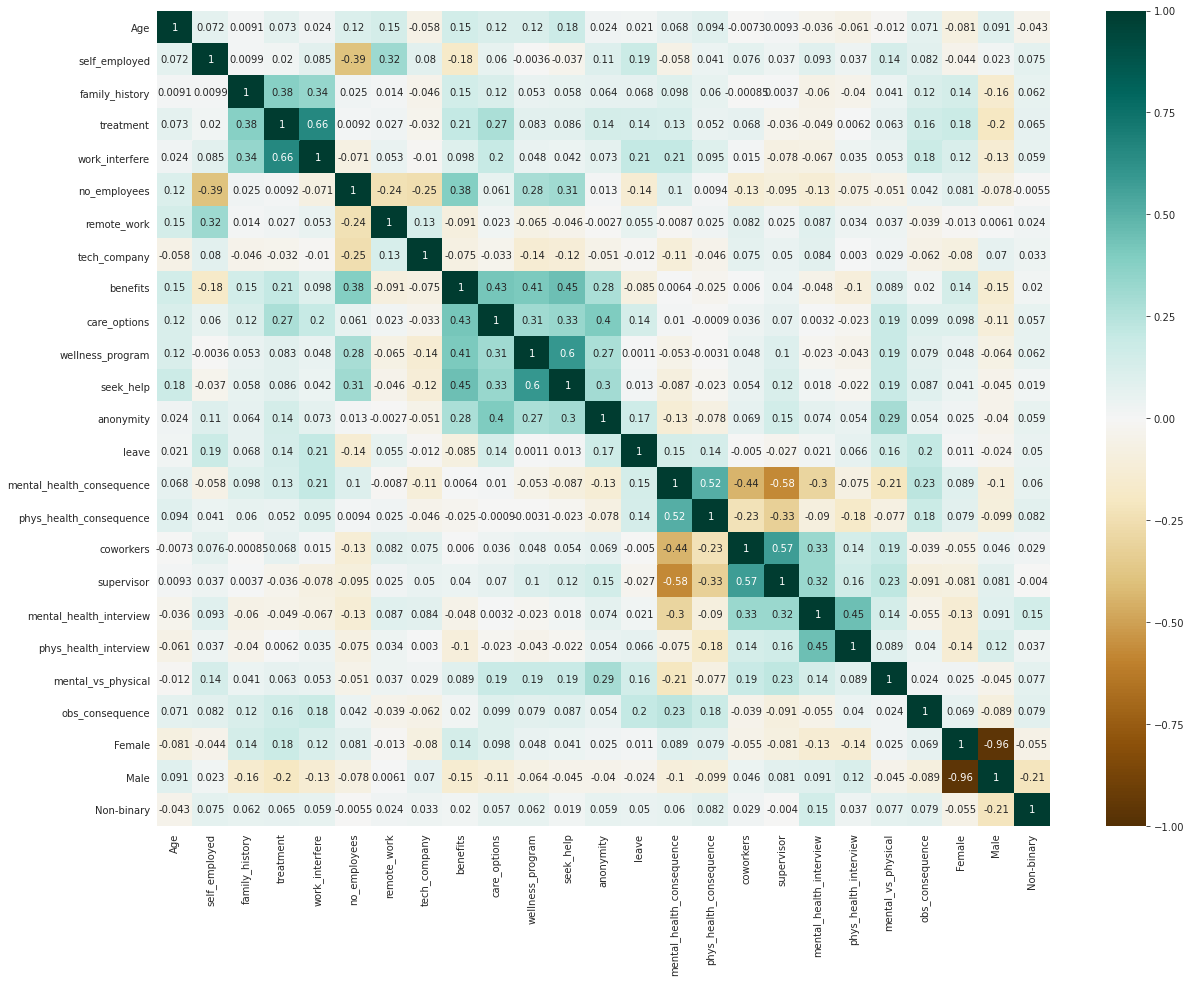

In [88]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, cmap="BrBG", vmax=1, vmin=-1)

### Задаем таргет и фичи для дальнейшего обучения

In [56]:
target = 'treatment'
features = ['Age',
            'self_employed',
            'family_history',
            'work_interfere',
            'no_employees',
            'remote_work',
            'tech_company',
            'benefits',
            'care_options',
            'wellness_program',
            'seek_help',
            'anonymity',
            'leave',
            'mental_health_consequence',
            'phys_health_consequence',
            'coworkers',
            'supervisor',
            'mental_health_interview',
            'phys_health_interview',
            'mental_vs_physical',
            'obs_consequence',
           'Female',
           'Male',
           'Non-binary']

In [57]:
x = df[features].to_numpy()
y = df[target].to_numpy()

### Применяем standard scaler для нормализации наших данных и делим данные на train и test в соотношении 80/20.

In [58]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
x_norm.shape

(1259, 24)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.2, random_state=10)
x_train.shape, x_test.shape

((1007, 24), (252, 24))

## Обучение. Для оценки модели была применена метрика recall.


### Логистическая регрессия


In [60]:
#Model
logreg = LogisticRegression(C=0.01)
logreg.fit(x_train, y_train)

#prediction
y_pred_train = logreg.predict(x_train)
y_pred_test = logreg.predict(x_test)


logreg_score_train = round(recall_score(y_pred_train, y_train) * 100, 2)
logreg_score_test = round(recall_score(y_pred_test, y_test) * 100, 2)

print(f" Recall on train is {logreg_score_train}")
print(f" Recall on test is {logreg_score_test}")

 Recall on train is 82.14
 Recall on test is 77.78


### Метод ближайших соседей


In [61]:
neighbors = KNeighborsClassifier(n_neighbors = 5)

neighbors.fit(x_train, y_train)

y_pred_test = neighbors.predict(x_test)
y_pred_train = neighbors.predict(x_train)

neighbors_score_train = round(recall_score(y_pred_train, y_train) * 100, 2)
neighbors_score_test = round(recall_score(y_pred_test, y_test) * 100, 2)

print(f" Recall on train is {neighbors_score_train}")
print(f" Recall on test is {neighbors_score_test}")

 Recall on train is 87.86
 Recall on test is 80.0


### Метод опорных векторов

In [62]:
clf = SVC(C=0.01, kernel='sigmoid')
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

svm_score_train = round(recall_score(y_pred_train, y_train) * 100, 4)
svm_score_test = round(recall_score(y_pred_test, y_test) * 100, 4)

print(f" Recall on train is {svm_score_train}")
print(f" Recall on test is {svm_score_test}")

 Recall on train is 80.8081
 Recall on test is 78.2258


### Дерево Решений

In [63]:
tree = DecisionTreeClassifier(criterion = 'gini',
                             max_depth = 2,
                             min_samples_leaf = 2,
                              max_features=None
                             )

tree.fit(x_train, y_train)

y_pred_test = tree.predict(x_test)

tree_score_test = round(recall_score(y_pred_test, y_test) * 100, 4)

print(tree_score_test)

75.4717


### Grid search + Decision Tree

In [64]:
# Grid search + cross validation

clf = DecisionTreeClassifier()

# будут рассмотрены все возможные комбинаци этих значений
param_grid = {'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.5, 'sqrt', None]
}

dt = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='recall',
    cv=5, 
    verbose=4 
)

In [65]:
dt.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2, score=0.971, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2, score=0.941, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2, score=0.960, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2, score=0.762, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=0.5, min_samples_split=2, score=0.733, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=0.5, min_samples_spl

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=2, score=0.960, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=2, score=0.960, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=0.5, min_samples_split=2 
[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=2, score=0.931, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5 
[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5, score=0.971, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5 
[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5, score=0.951, total=   0.0s
[CV] criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5 
[CV]  criterion=gini, max_depth=3, max_features=0.5, min_samples_split=5, score=0.960, total=   0.0s
[CV] criterion=gini, max_dept

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    2.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [66]:
dt.best_score_, dt.best_params_

(0.9585905649388469,
 {'criterion': 'gini',
  'max_depth': 3,
  'max_features': 0.5,
  'min_samples_split': 10})

In [68]:
dt_test = round(recall_score(y_test, dt.best_estimator_.predict(x_test))*100, 2)
dt_train = round(recall_score(y_train, dt.best_estimator_.predict(x_train))*100, 2)

In [86]:
# Результаты 
print(f" Recall on test is {round(recall_score(y_test, dt.best_estimator_.predict(x_test))*100, 2)}")
print(f" Recall on train is {round(recall_score(y_train, dt.best_estimator_.predict(x_train))*100, 2)}")

 Recall on test is 87.69
 Recall on train is 88.36


### Grid search and random forest

In [71]:
#  Grid search + cross validation
rfc = RandomForestClassifier()
param_grid = {       
     'n_estimators' : [80, 160, 500, 1000],
     'criterion' : ['gini', 'entropy'],
     'max_depth' : [3, 5, 10],
     'min_samples_split' : [2,3]   
    }

gs = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring=['recall'], 
    refit='recall',
    cv=5,
    verbose=4, 
    n_jobs=-1,
)

In [72]:
gs.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [73]:
random_forest_test = round(recall_score(y_test, gs.best_estimator_.predict(x_test))*100, 2)
random_forest_train = round(recall_score(y_train, gs.best_estimator_.predict(x_train))*100, 2)

In [87]:
# Результаты 
print(f" Recall on test is {round(recall_score(y_test, gs.best_estimator_.predict(x_test))*100, 2)}")
print(f" Recall on train is {round(recall_score(y_train, gs.best_estimator_.predict(x_train))*100, 2)}")


 Recall on test is 87.69
 Recall on train is 92.5


### Grid search и xgboost


In [75]:
xgbc = XGBClassifier()
param_grid = { 
    'binary':['logistic'],
     'n_estimators' : [80, 160, 500, 1000],
     'max_depth' : [3, 5, 7, 10],
     'learning_rate' : [0.1, 0.01, 0.001],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'gamma': [0, 0.3, 0.5],
    'min_child_weight': [5, 6, 7, 8, 9, 10]
    }


cv = GridSearchCV(
    estimator=xgbc,
    param_grid=param_grid,
    scoring=['recall'],
    refit='recall',
    cv=5, 
    verbose=4, 
    n_jobs=-1, 
)

In [76]:
cv.fit(x_train, y_train)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1564 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 2961 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 4137 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 4798 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 5509 tasks      | el

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'binary': ['logistic'],
                         'booster': ['gbtree', 'gblinear', 'dart'],
                         'gamma': [0, 0.3, 0.5],
                         'learning_rate': [0.

In [77]:
xgboost_test = round(recall_score(y_test, cv.best_estimator_.predict(x_test))*100,2)
xgboost_train = round(recall_score(y_train, cv.best_estimator_.predict(x_train))*100,2)

In [78]:
# Результаты 
print(f" Recall on test is {round(recall_score(y_test, cv.best_estimator_.predict(x_test))*100,2)}")
print(f" Recall on train is {round(recall_score(y_train, cv.best_estimator_.predict(x_train))*100,2)}")

 Recall on test is 92.31
 Recall on train is 95.27


## Оформляем результаты в таблицу

In [80]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier'],
    'Recall': [logreg_score_test, neighbors_score_test, svm_score_test, dt_test, random_forest_test, xgboost_test]})
models.sort_values(by='Recall', ascending=False)

,Model,Recall
5,XGBClassifier,92.3100
3,DecisionTreeClassifier,87.6900
4,RandomForestClassifier,87.6900
1,KNN,80.0000
2,SVC,78.2258
0,Logistic Regression,77.7800
